**Lab #2**
- *Marcel Castro*
- *Ulises Fonseca*

# **1. Dataset election**

A dataset called "MBA Admission dataset, Class 2025" was chosen; the contained information is synthetic, meaning it is not real admission data.

We begin by loading libraries.

In [ ]:
import xgboost as xgb
import requests
import pandas as pd
from io import StringIO
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder, LabelBinarizer, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

We load the dataset.

In [ ]:
# GitHub
url = "https://raw.githubusercontent.com/ulisesfh02/LabsMachineLearning/master/Lab%232/Dataset/MBA.csv"

# Send a request to GitHub (no token needed for raw content)
response = requests.get(url)

# Load the CSV into a DataFrame
mba = pd.read_csv(StringIO(response.text), sep=',', on_bad_lines='skip')

In [ ]:
mba.head()

,application_id,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
0,1,Female,False,3.30,Business,Asian,620.0,3.0,Financial Services,Admit
1,2,Male,False,3.28,Humanities,Black,680.0,5.0,Investment Management,NaN
2,3,Female,True,3.30,Business,NaN,710.0,5.0,Technology,Admit
3,4,Male,False,3.47,STEM,Black,690.0,6.0,Technology,NaN
4,5,Male,False,3.35,STEM,Hispanic,590.0,5.0,Consulting,NaN


# **2. Data Preprocessing**



2.1. Now we handle missing values in the dataset.

In [ ]:
null_values = mba.isnull().sum()
print(null_values)

application_id       0
gender               0
international        0
gpa                  0
major                0
race              1842
gmat                 0
work_exp             0
work_industry        0
admission         5194
dtype: int64


We identified missing values in `race` and `admission`.  
For `race`, missing values will be replaced with "Not Disclosed".  
For `admission`, missing values will be replaced with "Decline".  
Additionally, the `application_id` column will be removed.

In [ ]:
mba = mba.drop(columns=['application_id'])
mba['race'].fillna('Prefer Not To Say', inplace=True)
mba['admission'].fillna('Decline', inplace=True)

2.2. We normalize the data.

In [ ]:
# Seleccionamos las columnas numéricas y categóricas por separado
numeric_columns = mba.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = mba.select_dtypes(exclude=['float64', 'int64']).columns

# Normalizamos las columnas numericas con MinMaxScaler
scaler_minmax = MinMaxScaler()
scaled_numeric_data_minmax = pd.DataFrame(scaler_minmax.fit_transform(mba[numeric_columns]), columns=numeric_columns)
mba = pd.concat([scaled_numeric_data_minmax, mba[categorical_columns]], axis=1)

# Reorder the columns to match the original order
mba = mba[['gender', 'international', 'gpa', 'major', 'race', 'gmat', 'work_exp', 'work_industry', 'admission', ]]

2.3. We encode the categorical variables using OneHotEncoding and LabelEncoding.  
Label Encoding will be used for the variables "gender", "international", and "admission", and One Hot Encoding for "major", "race", and "work_industry".

In [ ]:
# Label encoding para gender, international y admission
columns_to_labelencode = ['gender', 'international', 'admission']

# Aqui se guardan los label encoders
label_encoders = {}

# Aplicamos LabelEncoder a las columnas especificadas
for col in columns_to_labelencode:
    labelEncoder = LabelEncoder()
    mba[col] = labelEncoder.fit_transform(mba[col])  # Transformar las categorías en números
    label_encoders[col] = labelEncoder  # Guardar el encoder para referencia futura

# Label encoding para major, race y work_industry
columns_to_hotencode = ['major', 'race', 'work_industry']

# Inicializamos OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')

# Aplicamos One Hot Encoding
one_hot_encoded = encoder.fit_transform(mba[columns_to_hotencode])

# Convertimos el resultado en dataframe
one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(columns_to_hotencode))

# Concatenamos las columnas One Hot Encoded con el resto
mba = pd.concat([mba.drop(columns=columns_to_hotencode), one_hot_encoded_df], axis=1)

Now, we split the dataset into testing and training sets.

In [ ]:
x = mba.drop('admission', axis=1)  # Features
y = mba['admission']  # Class

# Dividimos el dataset en 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

# **3. Algorithm Selection** & **4. Model Training and Evaluation**

## **Three Algorithms Covered in Class**

The algorithms Logistic Regression, KNN, and Random Forest will be implemented.

Data observation: There are 6,194 entries. For the variable "admission", 84% have the value "Decline", 15% have the value "Admit", and the remaining 2% have the value "Waitlist". The data is quite imbalanced; therefore, techniques will be applied to try to achieve better results considering the bias that the data imbalance may cause.

### 4.1. **Logistic Regression**

In [ ]:
# Entrenamos el modelo de regresión logística
# Utilizaremos la SMOTE para intentar balancear los datos al agregar datos sintéticos de las clases minoritarias(Admit y Waitlist)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
logistic_model = LogisticRegression(solver='lbfgs', max_iter=1000)
# logistic_model.fit(X_train, y_train)
logistic_model.fit(X_train_smote, y_train_smote)
# Realizamos predicciones en el conjunto de prueba
y_pred_lr = logistic_model.predict(X_test)


Accuracy: 67.55%

Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.62      0.48       180
           1       0.95      0.69      0.80      1039
           2       0.06      0.55      0.10        20

    accuracy                           0.68      1239
   macro avg       0.46      0.62      0.46      1239
weighted avg       0.85      0.68      0.74      1239



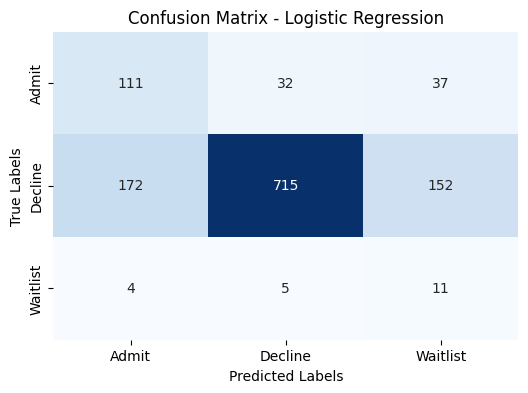

In [ ]:
# Evaluamos el modelo con métricas como accuracy, precision y recall. Además mostramos una matriz de confusión y obtenemos el valor ROC-AUC
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr, average='weighted', zero_division=1)
recall_lr = recall_score(y_test, y_pred_lr, average='weighted')
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)

# Creamos el reporte de clasificación
class_report_lr = classification_report(y_test, y_pred_lr, zero_division=1)

# Mostrar los resultados
print(f"Accuracy: {accuracy_lr * 100:.2f}%")
print("\nClassification Report:")
print(class_report_lr)

class_names = ['Admit', 'Decline', 'Waitlist']

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_lr, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

* After trying different techniques to improve classification results, it was concluded that using SMOTE can slightly improve performance. It can be seen that the precision for identifying Admit (0) and Waitlist (2) is quite low, due to the data imbalance. With SMOTE, the recall—which indicates how often each class is correctly identified—improved greatly for Admit and Waitlist, while for Decline it worsened due to the introduction of more samples in the minority classes. Finally, accuracy dropped from 84% to 67%, which might seem negative; however, this is compensated by the improved identification of the minority classes.

* The bias toward the Decline class is more evident in the confusion matrix, where most Decline samples were correctly predicted. However, there are also many false Decline predictions in Admit and Waitlist, which is a consequence of SMOTE since the oversampling may not perfectly reflect the real data distribution.


Mean of ROC-AUC score: 0.7927930740091121



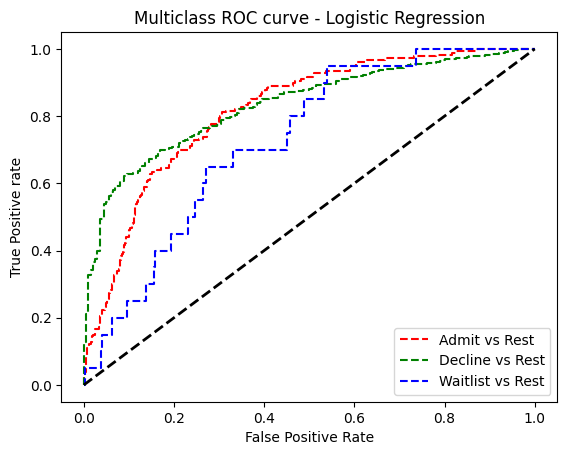

In [ ]:
oneVRestClassifier = OneVsRestClassifier(logistic_model)
oneVRestClassifier.fit(X_train_smote, y_train_smote)
pred = oneVRestClassifier.predict(X_test)
pred_prob = oneVRestClassifier.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 3
auc_score_lr = [0]*n_class

for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:,i], pos_label=i)
    auc_score_lr[i] = auc(fpr[i], tpr[i])

mean_auc_lr = sum(auc_score_lr) / n_class
print(f"Mean of ROC-AUC score: {mean_auc_lr}\n")

# plotting
plt.plot(fpr[0], tpr[0], linestyle='--',color='red', label='Admit vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Decline vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Waitlist vs Rest')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title('Multiclass ROC curve - Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.savefig('Multiclass ROC',dpi=300);

With an ROC-AUC score of 0.79, it can be said that the algorithm has a fairly good classification performance, largely due to the large amount of Decline data. In the graph, the curve with the poorest performance is that of Waitlist, which aligns with the numerical results obtained. The Decline curve shows somewhat better accuracy, but the Admit curve is not far behind.


### 4.2. **K-Nearest Neighbors (KNN)**

Accuracy: 68.52%

Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.53      0.37       180
           1       0.91      0.72      0.80      1039
           2       0.01      0.05      0.02        20

    accuracy                           0.69      1239
   macro avg       0.40      0.43      0.40      1239
weighted avg       0.80      0.69      0.73      1239



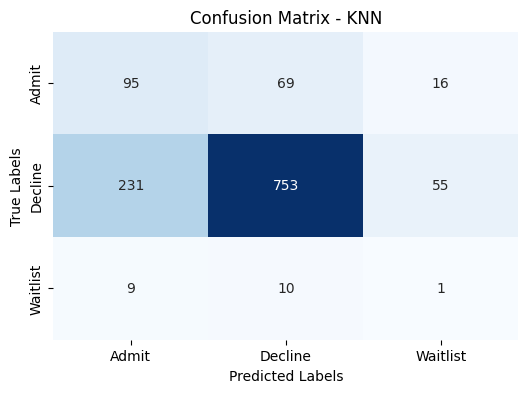

In [ ]:
# Entrenar el modelo K-Nearest Neighbors (KNN)
knn_model = KNeighborsClassifier(n_neighbors=5)

# Usar OneVsRest para manejar el problema multiclase
oneVRestClassifier = OneVsRestClassifier(knn_model)
oneVRestClassifier.fit(X_train_smote, y_train_smote)

# Hacer predicciones
y_pred_knn = oneVRestClassifier.predict(X_test)
y_pred_prob_knn = oneVRestClassifier.predict_proba(X_test)

# Evaluar el modelo
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn, average='weighted')
recall_knn = recall_score(y_test, y_pred_knn, average='weighted')
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)

# Ajustar el reporte de clasificación para evitar advertencias
class_report_knn = classification_report(y_test, y_pred_knn, zero_division=1)

# Mostrar los resultados
print(f"Accuracy: {accuracy_knn * 100:.2f}%")
print("\nClassification Report:")
print(class_report_knn)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_knn, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - KNN")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

* For KNN, the training data modified with SMOTE was also used, achieving an accuracy of 68%, largely due to correctly identifying data from the Decline class. For the Admit and Waitlist classes, precision and recall values were quite low, especially for Waitlist due to the low number of samples compared to Decline.

* The confusion matrix shows a high number of Decline predictions, both correct and incorrect, a smaller bias toward predicting Admit, and minimal prediction of Waitlist—in fact, only one correct Waitlist prediction was made.


Mean of ROC-AUC score: 0.6571930749492901



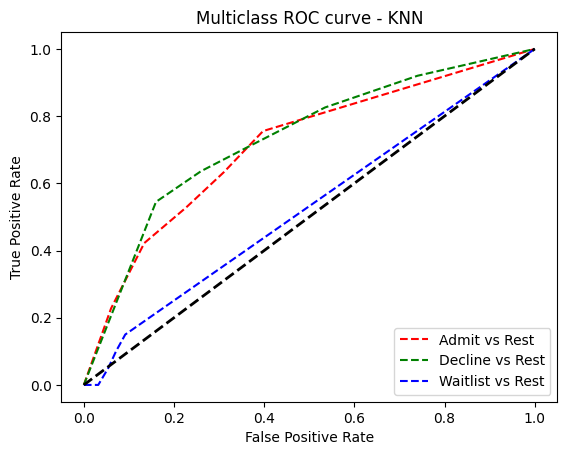

In [ ]:
# ROC Curve para las clases
fpr = {}
tpr = {}
thresh = {}
n_class = 3  # Número de clases
auc_score_knn = [0]*n_class

for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_prob_knn[:, i], pos_label=i)
    auc_score_knn[i] = auc(fpr[i], tpr[i])

mean_auc_knn = sum(auc_score_knn) / n_class
print(f"Mean of ROC-AUC score: {mean_auc_knn}\n")

# Graficar la curva ROC multiclase
plt.plot(fpr[0], tpr[0], linestyle='--', color='red', label='Admit vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--', color='green', label='Decline vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--', color='blue', label='Waitlist vs Rest')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title('Multiclass ROC curve - KNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

* The findings mentioned can be seen in the ROC-AUC value of 0.65, which, although not extremely low, is heavily biased toward identifying the Decline class. The graph clearly shows the poor performance in identifying the Waitlist class and a moderately good performance in identifying Admit and Decline.


### 4.3. **Random Forest**

Accuracy: 81.52%


Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.43      0.43       180
           1       0.89      0.90      0.89      1039
           2       0.00      0.00      0.00        20

    accuracy                           0.82      1239
   macro avg       0.44      0.44      0.44      1239
weighted avg       0.81      0.82      0.81      1239



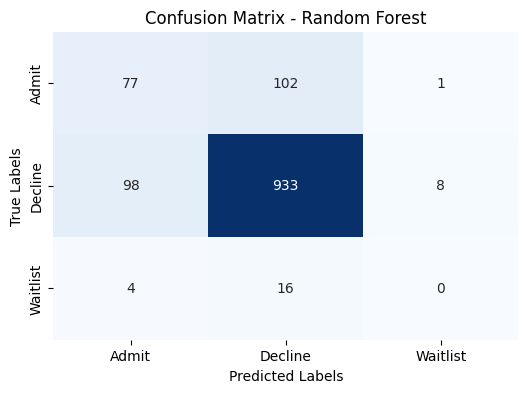

In [ ]:
# Entrenar el modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Usar OneVsRest para manejar el problema multiclase
oneVRestClassifier = OneVsRestClassifier(rf_model)
oneVRestClassifier.fit(X_train_smote, y_train_smote)

# Hacer predicciones
y_pred_rf = oneVRestClassifier.predict(X_test)
y_pred_prob_rf = oneVRestClassifier.predict_proba(X_test)

# Evaluar el modelo
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Ajustar el reporte de clasificación para evitar advertencias
class_report_rf = classification_report(y_test, y_pred_rf, zero_division=1)

# Mostrar los resultados
print(f"Accuracy: {accuracy_rf * 100:.2f}%")
print("\nClassification Report:")
print(class_report_rf)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

* For Random Forest, the data modified with SMOTE was used. A high precision and recall were observed for Decline, a moderate one for Admit—indicating it predicts Admit correctly less than half the time—while no correct predictions were obtained for Waitlist.  
* The confusion matrix reflects these findings: Waitlist was predicted only 9 times, all incorrectly. Most predictions were for Decline, and to a lesser extent for Admit, continuing to show the bias toward Decline due to class imbalance.


Mean of ROC-AUC score: 0.7604671535443219



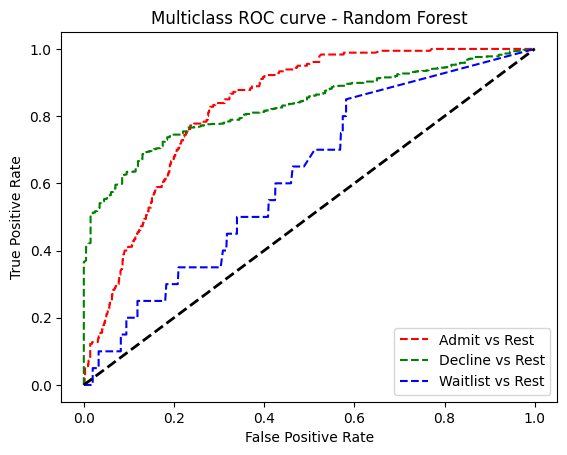

In [ ]:
# ROC Curve para las clases
fpr = {}
tpr = {}
thresh = {}
n_class = 3  # Número de clases
auc_score_rf = [0]*n_class

for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_prob_rf[:, i], pos_label=i)
    auc_score_rf[i] = auc(fpr[i], tpr[i])

mean_auc_rf = sum(auc_score_rf) / n_class
print(f"Mean of ROC-AUC score: {mean_auc_rf}\n")

# Graficar la curva ROC multiclase
plt.plot(fpr[0], tpr[0], linestyle='--', color='red', label='Admit vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--', color='green', label='Decline vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--', color='blue', label='Waitlist vs Rest')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title('Multiclass ROC curve - Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

* An ROC-AUC value of 0.76 was obtained, largely due to the identification of the Decline class and to a lesser extent the Admit class.  
* In the graph, the Waitlist curve is very close to the diagonal, evidencing poor predictive ability. For Decline, the curve started very accurate and then decreased, while for Admit, the growth was fairly steady, with the number of false positives remaining toward the end.


## **Two Additional Algorithms Not Covered in Class**

### 4.4. **Bagging**


**What is it and how does it work?**

It is an ensemble technique where multiple models (usually of the same type) are trained on different subsets of data generated by taking random samples with replacement from the training set. Then, the predictions of these models are combined by voting (for classification) or averaging (for regression).


Accuracy: 80.47%

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.35      0.36       180
           1       0.88      0.90      0.89      1039
           2       0.00      0.00      0.00        20

    accuracy                           0.80      1239
   macro avg       0.42      0.42      0.42      1239
weighted avg       0.79      0.80      0.80      1239



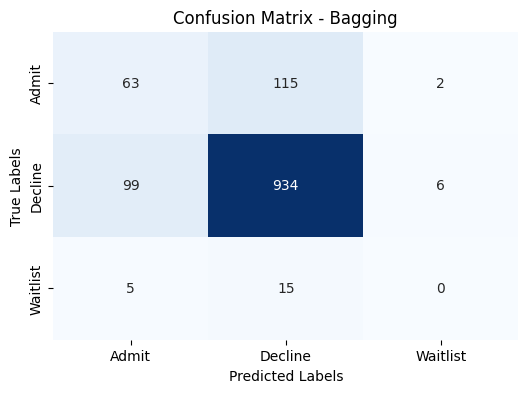

In [ ]:
# Crear el modelo Bagging con un árbol de decisión como estimador base
base_model = DecisionTreeClassifier()
bagging_model = BaggingClassifier(estimator=base_model, n_estimators=100, random_state=42)

# Usar OneVsRest para manejar el problema multiclase
oneVRestClassifier = OneVsRestClassifier(bagging_model)
oneVRestClassifier.fit(X_train_smote, y_train_smote)

# Hacer predicciones
y_pred_bagging = oneVRestClassifier.predict(X_test)
y_pred_prob_bagging = oneVRestClassifier.predict_proba(X_test)

# Evaluar el modelo
accuracy_bagging = accuracy_score(y_test, y_pred_bagging)
precision_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
conf_matrix_bagging = confusion_matrix(y_test, y_pred_bagging)

# Ajustar el reporte de clasificación para evitar advertencias
class_report_bagging = classification_report(y_test, y_pred_bagging, zero_division=1)

# Mostrar los resultados
print(f"Accuracy: {accuracy_bagging * 100:.2f}%")
print("\nClassification Report:")
print(class_report_bagging)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_bagging, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Bagging")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

* Bagging produced results similar to those obtained with Random Forest: high precision and recall for the Decline class, lower for Admit, and none for Waitlist. These findings are evident in the confusion matrix. Additionally, an accuracy of 80% was achieved.


Mean of ROC-AUC score: 0.7310748236226322



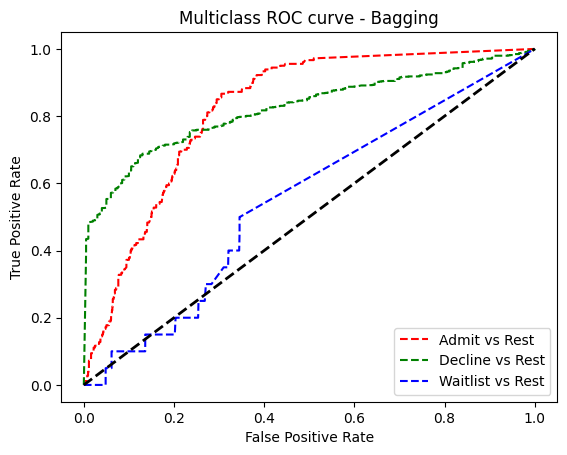

In [ ]:
# ROC Curve para las clases
fpr = {}
tpr = {}
thresh = {}
n_class = 3  # Número de clases
auc_score_bagging = [0]*n_class

for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_prob_bagging[:, i], pos_label=i)
    auc_score_bagging[i] = auc(fpr[i], tpr[i])

mean_auc_bagging = sum(auc_score_bagging) / n_class
print(f"Mean of ROC-AUC score: {mean_auc_bagging}\n")

# Graficar la curva ROC multiclase
plt.plot(fpr[0], tpr[0], linestyle='--', color='red', label='Admit vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--', color='green', label='Decline vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--', color='blue', label='Waitlist vs Rest')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title('Multiclass ROC curve - Bagging')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

* A ROC-AUC value of 0.73 was obtained; the results are very similar to those of Random Forest, and the ROC curve is evidence of this.


### 4.5. **XGBoost**

**What is it and how does it work?**

It is a decision tree–based algorithm that uses the boosting technique. In this technique, models are trained sequentially, correcting the errors of previous models, which continuously improves performance.


Accuracy: 79.98%

Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.26      0.29       180
           1       0.86      0.91      0.89      1039
           2       0.00      0.00      0.00        20

    accuracy                           0.80      1239
   macro avg       0.40      0.39      0.39      1239
weighted avg       0.77      0.80      0.79      1239



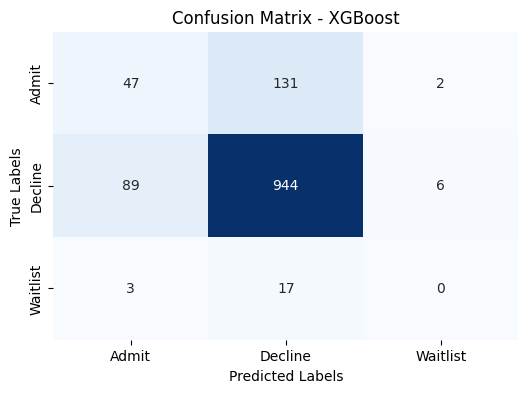

In [ ]:
# Crear y entrenar el modelo XGBoost
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='mlogloss')

# Usar OneVsRest para manejar el problema multiclase
oneVRestClassifier = OneVsRestClassifier(xgb_model)
oneVRestClassifier.fit(X_train_smote, y_train_smote)

# Hacer predicciones
y_pred_xgb = oneVRestClassifier.predict(X_test)
y_pred_prob_xgb = oneVRestClassifier.predict_proba(X_test)

# Evaluar el modelo
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb, average='weighted')
recall_xgb = recall_score(y_test, y_pred_xgb, average='weighted')
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

# Ajustar el reporte de clasificación para evitar advertencias
class_report_xgb = classification_report(y_test, y_pred_xgb, zero_division=1)

# Mostrar los resultados
print(f"Accuracy: {accuracy_xgb * 100:.2f}%")
print("\nClassification Report:")
print(class_report_xgb)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_xgb, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

* The findings for XGBoost remain similar to those of Random Forest and Bagging: a high ability to identify Decline, a much lower one for Admit, and none for Waitlist. The shape of the confusion matrix is also similar to the previous algorithms. An accuracy of 80% was achieved, again biased by the identification of the Decline class.


Mean of ROC-AUC score: 0.7640077122690948



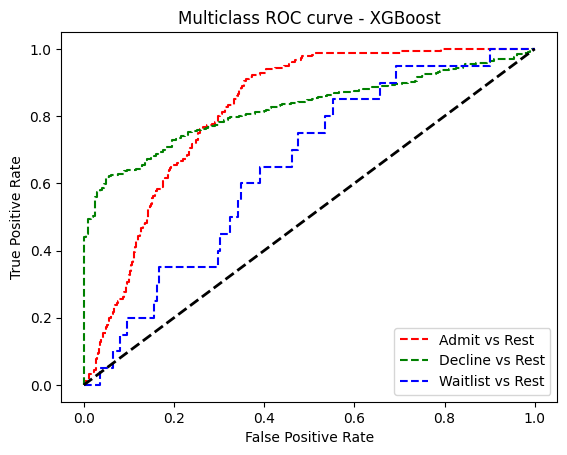

In [ ]:
# ROC Curve para las clases
fpr = {}
tpr = {}
thresh = {}
n_class = 3
auc_score_xgb = [0]*n_class

for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_prob_xgb[:, i], pos_label=i)
    auc_score_xgb[i] = auc(fpr[i], tpr[i])

mean_auc_xgb = sum(auc_score_xgb) / n_class
print(f"Mean of ROC-AUC score: {mean_auc_xgb}\n")

# Graficar la curva ROC multiclase
plt.plot(fpr[0], tpr[0], linestyle='--', color='red', label='Admit vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--', color='green', label='Decline vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--', color='blue', label='Waitlist vs Rest')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title('Multiclass ROC curve - XGBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

* A ROC-AUC value of 0.76 was obtained; the results are very similar to Random Forest, and the ROC curve is evidence of this.


### **Explanation of the operation and principles of the two algorithms**


**In the case of Bagging:**

*Principles*  
- Combines the results of multiple independently trained models to improve accuracy and reduce prediction variance.  
- Based on the bootstrap concept: multiple random subsets are generated from the original training set, with some points possibly repeated and others absent in certain subsets.

*Operation*  
1. Sampling with replacement: Multiple subsets of the training set are created.  
2. Independent training: A model (usually a decision tree, but it can be any algorithm) is trained on each subset.  
3. Aggregation: For the final prediction, the results of all trained models are combined. In classification, majority voting determines the final class; in regression, model outputs are averaged.

**In the case of XGBoost:**

*Principles*  
- Sequentially trains a series of models, correcting errors from previous models. It is an optimized implementation of Gradient Boosting.  
- Unlike Bagging, where models train independently, Boosting trains each model to fix errors made by its predecessor.  
- Focuses on minimizing a loss function using gradient descent to adjust models at each iteration.

*Operation*  
- Sequential training: A base model (usually a decision tree) is trained first. At each subsequent iteration, a new model focuses on correcting the errors of the previous one.  
- Data weights: The algorithm adjusts the weights of incorrectly predicted observations, giving them more importance in the next iterations.  
- Gradient-based fitting: Later models are adjusted by minimizing residual errors of previous models using the gradient of the loss function.  
- Regularization: Includes regularization techniques (like L1 and L2) to prevent overfitting.


# **5. Model Benchmarking**

Now, a comparison of the different implemented models is presented.


In [ ]:
results = [["Regresión Logística", accuracy_lr, mean_auc_lr, precision_lr, recall_lr],
           ["KNN", accuracy_knn, mean_auc_knn, precision_knn, recall_knn],
           ["Random Forest", accuracy_rf, mean_auc_rf, precision_rf, recall_rf],
           ["Bagging", accuracy_bagging, mean_auc_bagging, precision_bagging, recall_bagging],
           ["XGBoost", accuracy_xgb, mean_auc_xgb, precision_xgb, recall_xgb]]

result_col_name = ["Modelo", "Accuracy", "ROC-AUC", "Precision", "Recall"]

results_df = pd.DataFrame(results, columns=result_col_name)

results_df

,Modelo,Accuracy,ROC-AUC,Precision,Recall
0,Regresión Logística,0.675545,0.792793,0.854395,0.675545
1,KNN,0.685230,0.657193,0.800377,0.685230
2,Random Forest,0.815174,0.760467,0.806923,0.815174
3,Bagging,0.804681,0.731075,0.790927,0.804681
4,XGBoost,0.799839,0.764008,0.774049,0.799839


# **6. Documentation and Analysis**

## **Discussion of Limitations of Each Model and Suggestions for Improvements**

### 1. **Logistic Regression**
- **Limitations**:
  - **Assumes linearity**: Logistic regression assumes a linear relationship between features and class probabilities. If data is nonlinear, the model cannot capture complex relationships.
  - **Lower performance on complex datasets**: For multiclass problems and complex features, logistic regression tends to underperform.
  - **Lower recall**: Although it has high precision, the model exhibits low recall, meaning it misses many true positives.

- **Improvements**:
  - **Add polynomial features**: Include feature transformations to help the model capture nonlinearities.
  - **Regularization**: Tune regularization hyperparameters like `C` to avoid overfitting and improve generalization.
  - **Use nonlinear models**: Consider models that do not rely on linearity, such as **Random Forest** or **XGBoost**.

### 2. **K-Nearest Neighbors (KNN)**
- **Limitations**:
  - **Sensitivity to noise**: KNN can be sensitive to noisy data and outliers since classification depends on nearest neighbors.
  - **Computational cost**: Prediction with KNN is slow on large datasets as it calculates distances for every new sample.
  - **Lower ROC-AUC**: The model shows the lowest ROC-AUC, indicating limited class separation ability.

- **Improvements**:
  - **Feature scaling**: Ensure features are well scaled so distances are meaningful.
  - **Optimize k value**: Test various `k` values and use cross-validation to find the best.
  - **Dimensionality reduction**: Apply techniques like **PCA** or **t-SNE** to reduce feature space and speed up predictions.

### 3. **Random Forest**
- **Limitations**:
  - **Resource consumption**: While training is relatively fast, it can be memory and CPU intensive on large datasets.
  - **Interpretability**: Less interpretable than simpler models like logistic regression.
  - **Minority class bias**: Tends to underperform on minority classes without class weight adjustment or balancing.

- **Improvements**:
  - **Hyperparameter tuning**: Experiment with tree depth, number of estimators, etc.
  - **Balancing techniques**: Use oversampling or class weights to improve minority class performance.
  - **Interpretability tools**: Employ tools like **SHAP** or **LIME** to better understand model decisions.

### 4. **Bagging**
- **Limitations**:
  - **Efficiency**: Bagging improves stability and reduces overfitting but may be less efficient than methods like **Random Forest** or **XGBoost**.
  - **Does not capture dependencies**: Unlike boosting, bagging models are independent and do not correct errors sequentially.
  - **Limited performance**: Typically performs worse than more advanced models like **Random Forest** and **XGBoost**.

- **Improvements**:
  - **Use more complex base models**: Employ deeper decision trees or other complex base learners.
  - **Hyperparameter tuning**: Adjust number of models and sample sizes.
  - **Consider boosting**: Use boosting methods such as **XGBoost** or **Gradient Boosting Machines** for improved performance on complex problems.

### 5. **XGBoost**
- **Limitations**:
  - **Computational cost**: More expensive to train than **Random Forest** or **Bagging**.
  - **Overperformance on small datasets**: May not significantly outperform simpler models on small or less complex data.
  - **Minority class challenges**: Like Random Forest, can struggle with minority classes without class weight adjustment or balancing.

- **Improvements**:
  - **Hyperparameter tuning**: Perform thorough search on learning rate, max depth, etc.
  - **Class balancing**: Use the **scale_pos_weight** parameter to improve minority class recall.
  - **Regularization**: Apply L1 or L2 regularization to prevent overfitting on small datasets.

### General Conclusion:
- **Random Forest** is the best model in terms of precision and balanced precision-recall. It could be further improved by hyperparameter tuning and class balancing techniques.
- **XGBoost** is a strong choice for complex problems but has higher computational cost. It benefits from hyperparameter tuning and class balancing.
- **Models like KNN and Bagging** are less effective but might improve with hyperparameter optimization and additional preprocessing.


## Model Analysis:

1. **Best Model - Random Forest**:
   - **Accuracy**: The **Random Forest** model has the highest accuracy with **81.52%**, indicating it correctly predicts the largest percentage of samples.
   - **Precision and Recall**: Although its precision is not the highest (logistic regression has higher precision), **Random Forest** presents the best balance between **precision** (80.69%) and **recall** (81.52%), meaning it is a stable model both for correct classification and for capturing the majority of true positives.
   - **ROC-AUC**: Although it does not have the highest **ROC-AUC** value, its **0.760** is quite decent and shows the model performs well in distinguishing between classes.

2. **XGBoost**:
   - **ROC-AUC**: The **XGBoost** model has the best **ROC-AUC** with **0.764**, meaning it is slightly better at distinguishing between classes in terms of false positive and true positive rates.
   - **Precision**: Its precision and recall are high (**79.98%** precision and **79.98%** recall), but not as good as **Random Forest**.
   - **Balance**: XGBoost offers solid performance in all aspects but is outperformed by **Random Forest** in terms of precision and recall.

3. **Bagging**:
   - The **Bagging** model performs very similarly to **XGBoost**, with an accuracy of **80.46%** and a **ROC-AUC** of **0.731**. However, its precision is slightly lower than both **Random Forest** and **XGBoost**.

4. **Logistic Regression and KNN**:
   - Both models have lower accuracy compared to **Random Forest** and **XGBoost**. However, **logistic regression** has a high precision (**85.43%**), but at the cost of lower **recall**, meaning it tends to classify positives correctly but may miss many true positives.
